In [1]:
##This code reads an APPLE stock database and learns to predict the opening price. I am using LSTM in Keras to train 
#and test the model. I am also testing the effect of feature standardization and scaling on the results

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
import os

Using TensorFlow backend.


In [2]:
missing_values = ['na','--','?','-','None','none','non','null','NaN','']
X_data = pd.read_csv("AAPL_data.csv")


In [3]:
X_data.head(10)


,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
5,2013-02-15,66.9785,67.1656,65.7028,65.7371,97924631,AAPL
6,2013-02-19,65.8714,66.1042,64.8356,65.7128,108854046,AAPL
7,2013-02-20,65.3842,65.3842,64.1142,64.1214,118891367,AAPL
8,2013-02-21,63.7142,64.1671,63.2599,63.7228,111596821,AAPL
9,2013-02-22,64.1785,64.5142,63.7999,64.4014,82583823,AAPL


In [4]:
X_data.shape

(1259, 7)

In [5]:
seq_l = 50   ##this determines the sequence of each entry for the training set
X_train = X_data.open[0:int(0.8*X_data.shape[0])]
X_test = X_data.open[int(0.8*X_data.shape[0])-seq_l:]

In [6]:
X_train.shape

(1007,)

In [7]:
##first I am standarizing the opening price using the mean and the standard deviation
mean_val = X_train.mean()
dev = X_train.std()

X_train = (X_train - mean_val)/dev
X_test = (X_test-mean_val)/dev

In [8]:

X_data.open.min()

55.4242

In [9]:
#function to convert raw data into a sequence input for the LSTM
def convert_to_sequence(df,seq_l):
    m = df.shape[0]
    x = np.zeros((m-seq_l,seq_l))
    y = np.zeros(m-seq_l)
    for i in range(0,m-seq_l):
        x[i,:] = df[i:i+seq_l]
        y[i] = df[i+seq_l]
    
    return x,y

In [10]:
x_seq,y_seq = convert_to_sequence(X_train,seq_l)

In [11]:
x_seq = np.reshape(x_seq,(x_seq.shape[0],x_seq.shape[1],1))
y_seq = np.reshape(y_seq,(y_seq.shape[0],1))

In [12]:
#Building Keras LSTM model
model = Sequential()
model.add(LSTM(units=120,return_sequences=True,input_shape=(x_seq.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=120,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=120,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 120)           58560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 120)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 120)           115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 120)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [13]:
#Training model
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error',optimizer=opt)
model.fit(x_seq,y_seq, epochs = 50, batch_size = 32)


Epoch 1/50
957/957 [==============================] - 10s 11ms/step - loss: 0.1609
Epoch 2/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0438
Epoch 3/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0344
Epoch 4/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0309
Epoch 5/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0280
Epoch 6/50
957/957 [==============================] - 9s 10ms/step - loss: 0.0268
Epoch 7/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0239
Epoch 8/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0237
Epoch 9/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0214
Epoch 10/50
957/957 [==============================] - 9s 9ms/step - loss: 0.0228
Epoch 11/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0229
Epoch 12/50
957/957 [==============================] - 8s 8ms/step - loss: 0.0215
Epoch 13/50
957/957 [

In [14]:
X_test=X_test.reset_index(drop=True)
X_test

0      0.646513
1      0.660647
2      0.630023
3      0.668657
4      0.610470
         ...   
297    3.286612
298    3.231723
299    2.906628
300    2.705446
301    3.094382
Name: open, Length: 302, dtype: float64

In [15]:
#Building sequences for test data
x_test,y_test = convert_to_sequence(X_test,seq_l)

In [16]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
pred = model.predict(x_test)

In [17]:
pred[0:5]

array([[1.5225976],
       [1.569466 ],
       [1.5957861],
       [1.6273245],
       [1.657675 ]], dtype=float32)

In [18]:
y_test.shape

(252,)

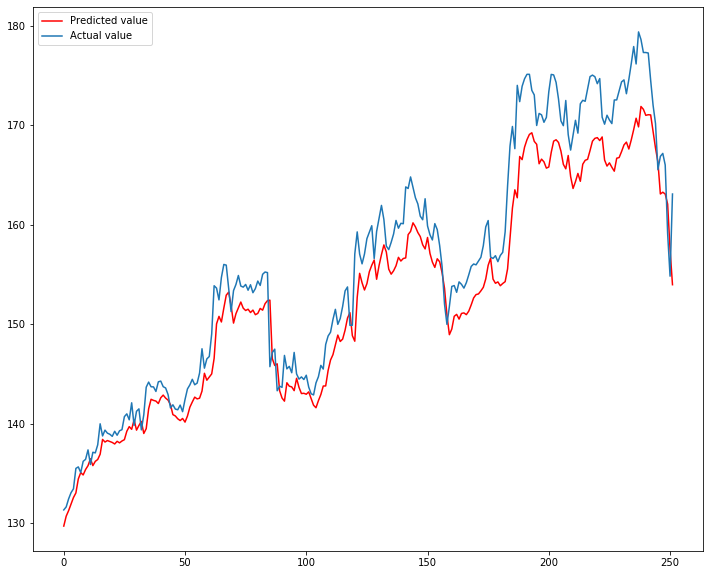

In [19]:
#plotting and comparing data
a4_dims = (12, 10)
fig, ax = plt.subplots(figsize=a4_dims)
xa = np.arange(0,252)
plt.plot(pred*dev+mean_val,'r')
plt.plot(xa,y_test*dev + mean_val)
plt.legend(('Predicted value','Actual value'))

In [20]:
X_train_scale = X_data.open[0:int(0.8*X_data.shape[0])]
X_test_scale = X_data.open[int(0.8*X_data.shape[0])-seq_l:]
max_val = X_train_scale.max()
min_val = X_train_scale.min()


In [21]:
#observe effect of scaling data between 0 and 1
X_train_scale = (X_train_scale - min_val)/(max_val-min_val)
X_test_scale = (X_test_scale - min_val)/(max_val-min_val)

In [22]:
x_seq,y_seq = convert_to_sequence(X_train_scale,seq_l)

In [23]:
x_seq = np.reshape(x_seq,(x_seq.shape[0],x_seq.shape[1],1))
y_seq = np.reshape(y_seq,(y_seq.shape[0],1))

In [24]:
model.compile(loss='mean_squared_error',optimizer=opt)
model.fit(x_seq,y_seq, epochs = 50, batch_size = 32)

Epoch 1/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0164
Epoch 2/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0040
Epoch 3/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0028
Epoch 4/50
957/957 [==============================] - 8s 9ms/step - loss: 0.0024
Epoch 5/50
957/957 [==============================] - 9s 10ms/step - loss: 0.0025
Epoch 6/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0023
Epoch 7/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0024
Epoch 8/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0019
Epoch 9/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0020
Epoch 10/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0025
Epoch 11/50
957/957 [==============================] - 11s 11ms/step - loss: 0.0020
Epoch 12/50
957/957 [==============================] - 9s 10ms/step - loss: 0.0020
Epoch 13/

In [25]:
X_test_scale=X_test_scale.reset_index(drop=True)
x_test,y_test = convert_to_sequence(X_test_scale,seq_l)

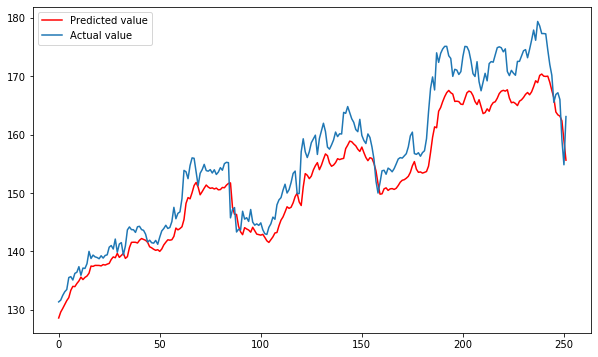

In [26]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
pred_scale = model.predict(x_test)
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(pred_scale*(max_val-min_val)+min_val,'r')
plt.plot(y_test*(max_val-min_val)+min_val)
plt.legend(('Predicted value','Actual value'))